# Task 4 Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [1]:

import numpy as np
# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    result = 0
    for i in range(len(p1)):
        result=((p1[i]-p2[i])**2)+result
    result=result**0.5
    return result

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"


#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [3]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distance=[euclidean_distance(datapoint, element) for element in centroids]
    return distance.index(np.min(distance))

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"


#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [3]:
import random
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = random.sample(list(data),k)
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [4]:

MAX_ITERATIONS = 100

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations<=MAX_ITERATIONS:
    # check if the centroids don't move (or very slightly)
        if sum([euclidean_distance(centroids[i], old_centroids[i])
            for i in range(len(centroids))])<=threshold:
            print("num_iterations:",num_iterations)
            print("bingo!")
            return True
    else:
        return False

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [5]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    for  i in range(len(centroids)):
        centroids[i]=sum(cluster[i])/len(cluster[i])
    return centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [6]:

# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data,k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for datapoint in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(datapoint, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(datapoint)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if (check_converge(centroids, old_centroids, iterations, threshold=0)):
            return centroids



Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/sklearn/utils/fixes.py:64: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if 'order' in inspect.getargspec(np.copy)[0]:


num_iterations: 6
bingo!


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


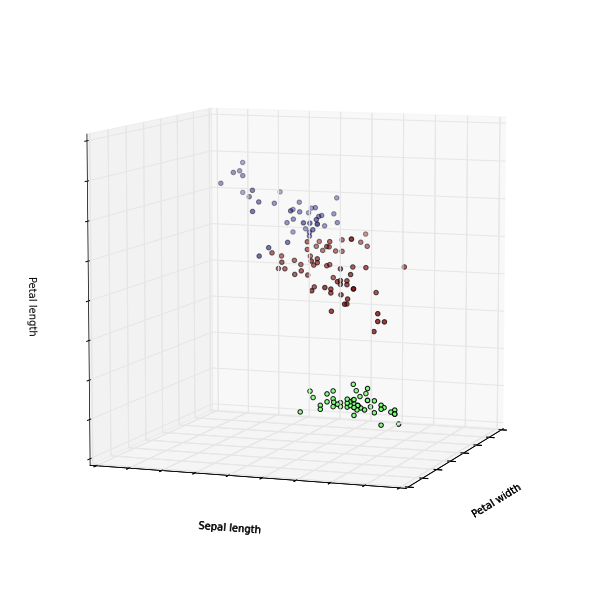

In [7]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

# moon
# np.random.seed(0)
# X, y = datasets.make_moons(2000, noise=0.2)

# blob
# np.random.seed(0)
# X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

# centers = kmeans(X, k=3)
# labels = [find_closest_centroid(p, centers) for p in X]

# fig = plt.figure(1, figsize=(8, 8))
# plt.clf()
# plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


<div class="alert alert-warning">


According to the resulte above, K means clustering gave a relatively reasonable result on this Iris data compared with the true value displayed above.
However, in the two clusters above, there are some points that are slightly different with the true classes, even we raise the MAX_ITERATION from 1,000 to 50,000(see the cell below), it doesn't change. We can consider this as a local minimum of K means clustering on this Iris data set.

</div>

num_iterations: 7
bingo!


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


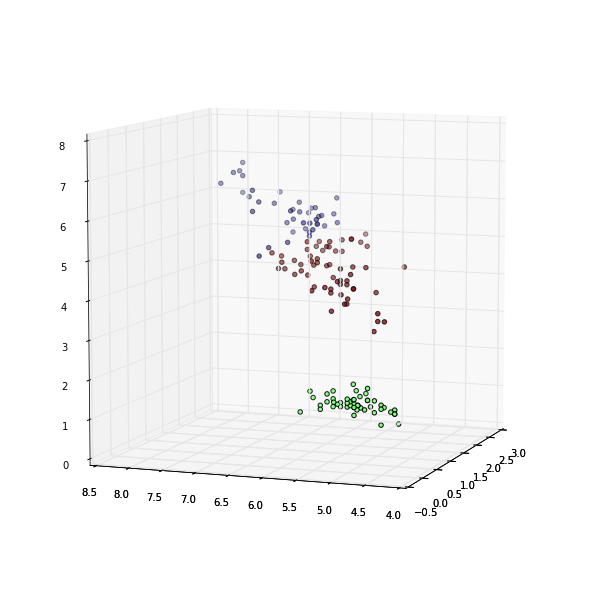

In [14]:
#Run K means clustering with MAX_ITERATIONS = 50,000
MAX_ITERATIONS = 50000
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


num_iterations: 14
bingo!


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


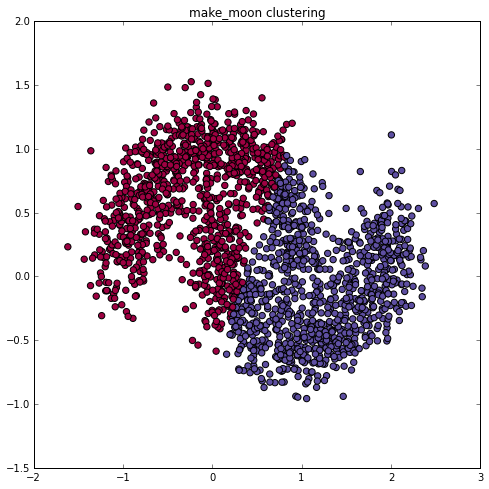

In [15]:
MAX_ITERATIONS = 1000
np.random.seed(0)
X, y = datasets.make_moons(2000, noise=0.2)

centers = kmeans(X, k=2)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.title("make_moon clustering")
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


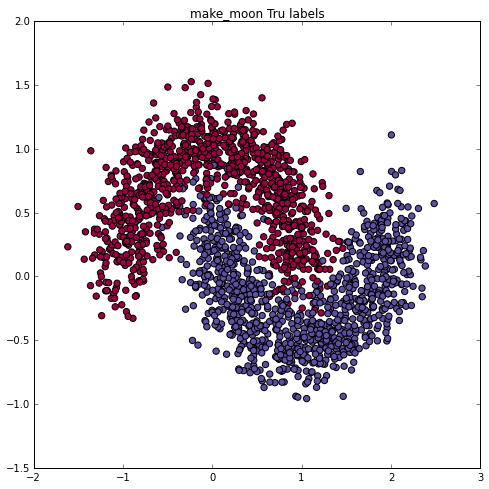

In [16]:
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("make_moon Tru labels")

<div class="alert alert-warning">


After testing the k means clustering algorithm on the make_moons dataset, we found the result is not quite evident. K means cannot identify clearly these two clusters.



</div>

num_iterations: 3
bingo!


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


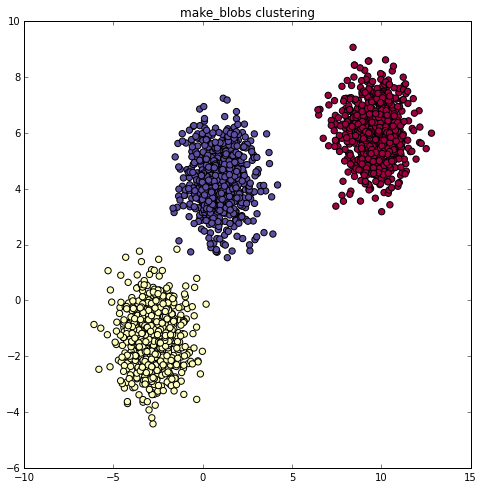

In [18]:
#blob
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)
plt.title("make_blobs clustering")

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


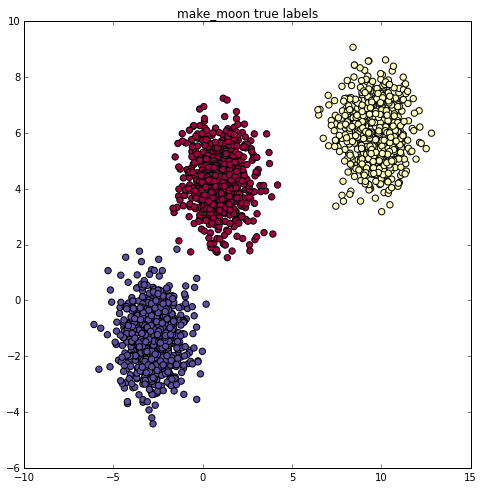

In [19]:
#blob True Value

X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.title("make_moon true labels")

<div class="alert alert-warning">


For the blobs data set, the k means clustering works perfectly and distinguish three clusters without error.




</div>

# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [2]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext 
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [3]:
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    del vector[1:4]
    
    # convert each value from string to float
    vector=np.array([float(element) for element in vector])
    
    return (label, vector)

labelsAndData = raw_data.map(lambda x:parseLine(x))


# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
#n = data.count()

In [4]:
data.take(1)

[array([  0.00000000e+00,   2.15000000e+02,   4.50760000e+04,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00])]

In [4]:
abnormaldata=labelsAndData.filter(lambda x:x[0]!='normal.')
print(abnormaldata.count())

3925650


In [4]:
abnormaltype=abnormaldata.map(lambda x:x[0]).distinct().collect()
totaltype=abnormaltype+['normal.']


In [6]:
datatype=labelsAndData.countByKey()

In [7]:
print (datatype)

defaultdict(<class 'int'>, {'phf.': 4, 'imap.': 12, 'nmap.': 2316, 'back.': 2203, 'normal.': 972781, 'teardrop.': 979, 'rootkit.': 10, 'warezmaster.': 20, 'loadmodule.': 9, 'multihop.': 7, 'ipsweep.': 12481, 'guess_passwd.': 53, 'perl.': 3, 'ftp_write.': 8, 'satan.': 15892, 'spy.': 2, 'warezclient.': 1020, 'smurf.': 2807886, 'land.': 21, 'buffer_overflow.': 30, 'neptune.': 1072017, 'pod.': 264, 'portsweep.': 10413})


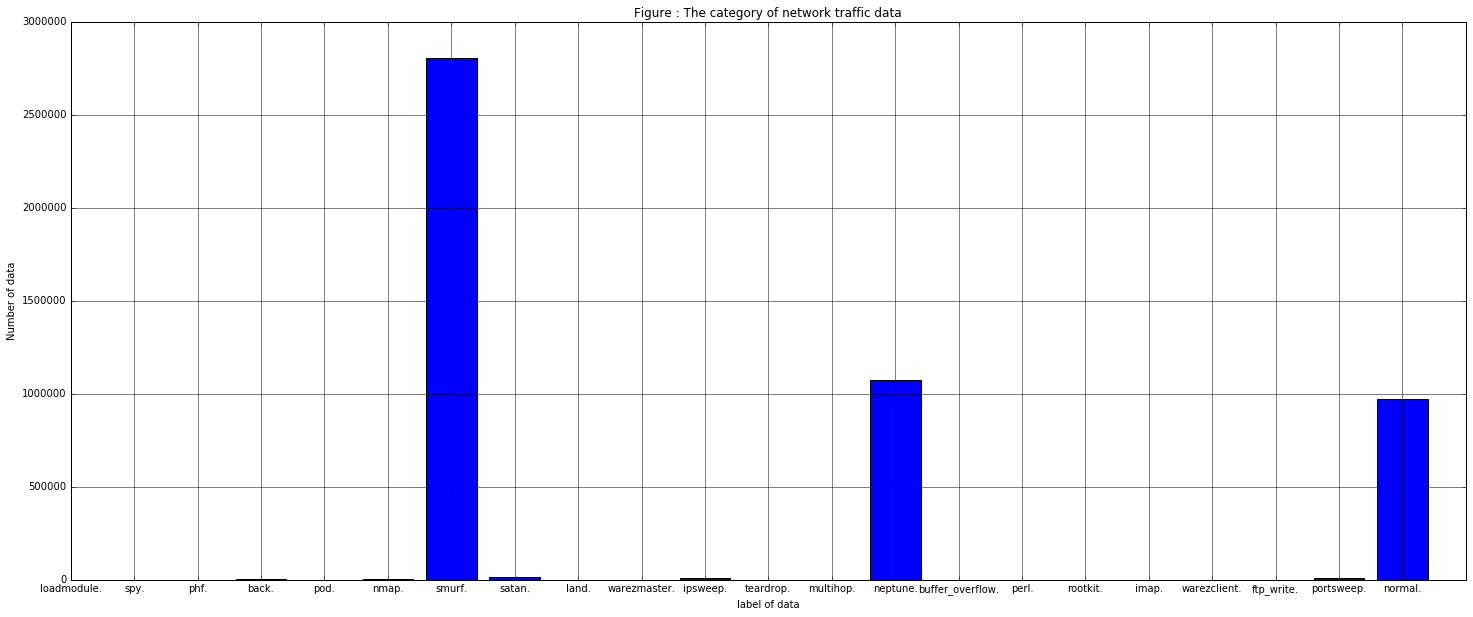

In [8]:
plt.figure(figsize=(25,10))
plt.xlabel("label of data")
plt.ylabel("Number of data")
plt.title('Figure : The category of network traffic data')
plt.grid(True,which="both",ls="-")
x= range(len(totaltype))
dataNumber= [datatype[totaltype[i]] for i in range(len(totaltype))]
plt.bar(x, dataNumber, align='center')
plt.xticks(x, totaltype)
plt.xlim(1,len(totaltype))
plt.show()

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [32]:
clusters = KMeans.train(data, k=2, maxIterations=10,initializationMode="random") 

In [7]:
centroids = clusters.clusterCenters
print (centroids)

[array([  2.74821895e-01,   3.01005405e+03,   2.38033751e+01,
         0.00000000e+00,   8.85226762e-05,   0.00000000e+00,
         1.59716782e-03,   0.00000000e+00,   3.79669998e-02,
         7.28005020e-04,   3.41786394e-07,   4.10143673e-06,
         7.71070106e-03,   7.99438377e-04,   1.16890947e-04,
         4.41929808e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   4.86709972e+02,   4.86726821e+02,
         5.26282690e-05,   5.56291536e-05,   4.19952943e-05,
         8.64890471e-05,   9.99257291e-01,   1.22471293e-03,
         1.39640352e-02,   2.49713700e+02,   2.49495913e+02,
         9.83206062e-01,   2.85938498e-03,   9.63889044e-01,
         5.63154606e-04,   2.83265728e-04,   1.04067121e-04,
         3.87397789e-04,   8.69641302e-05]), array([  1.19636396e+02,   9.12169640e+01,   2.68038098e+03,
         1.41942699e-05,   1.47975263e-03,   1.97705902e-05,
         2.85162882e-02,   7.95892989e-05,   3.00098802e-01,
         1.90051135e-02,   1.68810424e-

In [11]:
labelsRDD = clusters.predict(data)
labels = labelsRDD.collect()

In [9]:
a=np.array(data.map(lambda x: [x[1],x[2]]).collect())

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


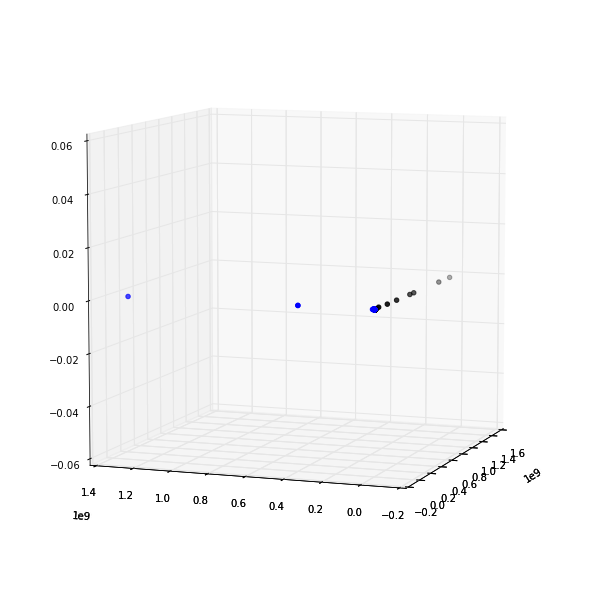

In [22]:
colors=[[0,0,labels[i]] for i in range(len(labels))]

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#plot the clusters in color

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(a[:, 0], a[:, 1],  color=colors)


<div class="alert alert-warning">


As the figure shown above, the data set as clearly assigned to 2 clusters with respect to the 2 feature "src_bytes" and "dst_bytes"


</div>

### 2.2.3. Evaluating model

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [4]:

from operator import add

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    centroids = clusters.centers
    print ("centroids:",centroids)
    distance=np.array([euclidean_distance(point, element) for element in centroids])
    minvalue=distance.min()
    return minvalue

WSSSE = data.map(lambda x: error(clusters, x)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))


NameError: name 'data' is not defined

In [10]:
def error(clusters, point):
    centroids = clusters.centers
    print ("centroids:",centroids)
    distance=np.array([euclidean_distance(point, element) for element in centroids])
    minvalue=distance.min()
    return minvalue


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [16]:
trueLabels = labelsAndData.map(lambda x:x[0])
labelPair = labelsRDD.zip(trueLabels)
clusterLabelCount = labelPair.countByValue()
for item in clusterLabelCount:
    print(item)

(0, 'loadmodule.')
(0, 'imap.')
(0, 'smurf.')
(0, 'land.')
(0, 'rootkit.')
(0, 'back.')
(0, 'normal.')
(0, 'pod.')
(0, 'spy.')
(0, 'guess_passwd.')
(0, 'phf.')
(0, 'nmap.')
(0, 'portsweep.')
(0, 'neptune.')
(0, 'teardrop.')
(0, 'satan.')
(0, 'buffer_overflow.')
(0, 'perl.')
(0, 'warezclient.')
(0, 'multihop.')
(0, 'warezmaster.')
(0, 'ipsweep.')
(0, 'ftp_write.')
(1, 'portsweep.')


<div class="alert alert-warning">

PUT YOUR COMMENT HERE

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [5]:
sampledData = data.sample(False, 0.01,10)

In [7]:
# k: the number of clusters
from operator import add
def MSE_kmeans(point,centroids):
    return (np.array([euclidean_distance(point, element) for element in centroids]).min())**2
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10)
    # calculate mean square error
    centroids = clusters.centers
    #distance=np.array([euclidean_distance(data, element) for element in centroids])
    #minvalue = distance.min()
    result = data.map(lambda x: MSE_kmeans(x,centroids)).reduce(add)/n
    return result
scores = []
for k in range(3,43,5):
    print("k = %d"%k)
    scores.append(clusteringScore(sampledData, k))
    

for score in scores:
    print(score)

# plot results
#plt...

k = 3
k = 8
k = 13
k = 18
k = 23
k = 28
k = 33
k = 38
137050663.505
43298319.6243
4929855.56505
4930633.26648
3809794.89651
4929855.46014
2490705.31586
2270038.91735


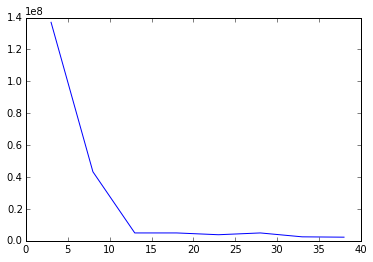

In [16]:
#scores = [190649369044.0,4817537433.54,965955156.664,380192994.966,147399018.826,106888294.157,62931941.5993,21009518.9921]
plt.plot(range(3,43,5), scores)

<div class="alert alert-warning">

As is shown in the figure above, the score decreases nearly monotonously along with the increasing of k. So in our example, when k = 38 we got the best results. The reason could be that with the number increasing of the clusters, the MSE value of each points decreases as these points are assigned to the closer cluster with respect to the lower k.

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

```python
def normalizeData(data):
    # number of connections
    n = ...

    # calculate the sum of each feature
    sums = ...
    print(sums)

    # calculate means
    means = ...

    # calculate the sum square of each feature
    sumSquares = ...
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = ...
    print(stdevs)

    def normalize(point):
        return ...

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))
```

In [6]:
from operator import add
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    sums = data.reduce(add)
    #print("sums:",sums)

    # calculate means
    #print("sums:",sums)
    means = sums/n

    # calculate the sum square of each feature
    sumSquares = data.map(lambda x : (x-means)**2).reduce(add)
    #print("sumSquares:",sumSquares)

    # calculate standard deviation of each feature
    stdevs = np.sqrt(sumSquares)
    #print("stdevs:",stdevs)

    def normalize(point):
        result = []
        for i in range(len(point)):
            if stdevs[i] != 0:
                result.append((point[i]-means[i])/stdevs[i])
            else:
                result.append(point[i]-means[i])
        return result

    return data.map(normalize)

normalizedData = normalizeData(sampledData).cache()
print(normalizedData.take(5))

[[-0.00029654155795799973, -0.00011493305460972303, 0.002700033574007007, 0.0, -6.3317951547049451e-05, 0.0, -0.00012797974074473545, -2.0475649335102411e-05, 0.011169952676180732, -8.0323934311679168e-05, -5.4176804125267449e-05, 0.0, -0.00012573696338666403, -3.3411606780892773e-05, -4.0952556497677581e-05, -0.00013432558324908992, 0.0, 0.0, -0.00014192776948939215, -0.0071479998352505375, -0.0053884841370472197, -0.0021381270732846345, -0.0021356489169971331, -0.0011303706594695936, -0.0011299351793560249, 0.0024751985676166781, -0.0011761663480422708, -0.00091584866190234644, -0.015088613021554002, -0.0071618032239438708, 0.0027337088715277528, -0.0012994581980685805, -0.0051796913984866275, -0.00071551181141030966, -0.0021405895391903617, -0.0021347319034736739, -0.0011430529761386247, -0.0011394115993042676], [-0.00029654155795799973, -9.0504130110990815e-05, 0.00083687653408704061, 0.0, -6.3317951547049451e-05, 0.0, -0.00012797974074473545, -2.0475649335102411e-05, 0.01116995267

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

```python
scores = ...
for score in scores:
    print(score)

plt...
```

1.336417816e-07
1.18773854817e-07
1.0139836182e-07
8.83573838632e-08
9.05963769199e-08
7.40658420097e-08
7.55347273176e-08
6.47750176771e-08
6.14261674487e-08
The best value of k is: 160


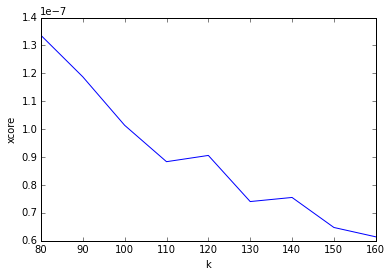

In [36]:
from operator import add
def MSE_kmeans(point,centroids):
    return (np.array([euclidean_distance(point, element) for element in centroids]).min())**2
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10)
    #calculate mean square error
    centroids = clusters.centers
    #distance=np.array([euclidean_distance(data, element) for element in centroids])
    #minvalue = distance.min()
    result = data.map(lambda x: MSE_kmeans(x,centroids)).reduce(add)/n
    return result
scores = []
kvalues=range(60,111,10)

for k in kvalues:
    print("k = %d:"%k)
    scores.append(clusteringScore(normalizedData, k))
for score in scores:
    print(score)
plt.plot(kvalues,scores)
plt.xlabel("k")
plt.ylabel("xcore")
print("The best value of k is:",kvalues[scores.index(np.min(scores))])


<div class='alert alert-warning'>

The figure above shows that k = 160 is the best number of clusters, with the score = 6.14261674487e-08


</div>

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [7]:
###@!SOLUTION@!####

# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x.split(',')[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
allData = labelsAndData.values().cache()
sampledAllData = allData.sample(False,0.01,10)

normalizedAllData = normalizeData(sampledAllData).cache()


### 2.3.2. Building models

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

k=80
running time:57
k=90
running time:51
k=100
running time:58
k=110
running time:51
k=120
running time:44
k=130
running time:53
k=140
running time:69
k=150
running time:74
k=160
running time:78
3.08706367819e-06
1.82943985597e-06
1.06710349331e-06
4.54590765971e-07
4.10857601622e-07
3.28928269903e-07
3.40662399296e-07
2.64436226733e-07
2.31663540118e-07
The best value of k is: 160


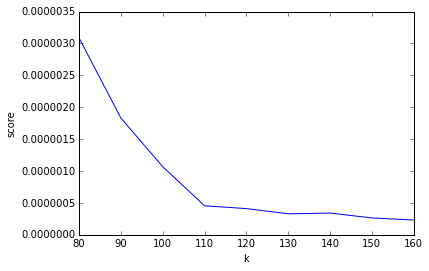

In [100]:
import time
from operator import add
def MSE_kmeans(point,centroids):
    return (np.array([euclidean_distance(point, element) for element in centroids]).min())**2
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10)
    # calculate mean square error
    centroids = clusters.centers
    #distance=np.array([euclidean_distance(data, element) for element in centroids])
    #minvalue = distance.min()
    result = data.map(lambda x: MSE_kmeans(x,centroids)).reduce(add)/n
    return result
scores = []
kvalues=range(80,161,10)
for k in kvalues:
    t0 = time.time()
    print("k=%d"%k)
    scores.append(clusteringScore(normalizedAllData, k))
    t1 = time.time()
    print("running time:%d"%(t1-t0))

for score in scores:
    print(score)


plt.plot(kvalues,scores)
plt.xlabel("k")
plt.ylabel("score")
print("The best value of k is:",kvalues[scores.index(np.min(scores))])


<div class="alert alert-warning">


PUT YOUR ANSWER HERE !!!


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [101]:
#training model with k = 160
import time
t0 = time.time()
clusters = KMeans.train(normalizedAllData, k=160, maxIterations=10)
centroids = clusters.centers
t1 = time.time()
print("running time:",t1-t0)

running time: 2.879173994064331


In [102]:
def distance_centroid(point, centroids):
    centroid_No=clusters.predict(point)
    result = euclidean_distance(point, centroids[centroid_No])
    return centroid_No,result
data_with_distance=normalizedAllData.map(lambda x:distance_centroid(x,centroids))#.zip(normalizedAllData).map(lambda x: (x[1],x[0][0],x[0][1]))

In [132]:
groupedCluster = data_with_distance.groupByKey().collect()
groupedCluster.sort()
def sorts(y):
    try:
        y = sorted(y)[99]
    except:
        y = sorted(y)[-1]
    return y

thresholds = [(x,sorts(y)) for (x,y) in groupedCluster]



In [142]:
def find_anomalous(point,centroids):
    centroid_No = clusters.predict(point)
    centroid = centroids[centroid_No]
    if euclidean_distance(point,centroid) <= thresholds[centroid_No][1]:
        return "Normal"
    return "Anomalous"
detected_data = normalizedAllData.map(lambda x : find_anomalous(x,centroids)).take(100)

<div class="alert alert-warning">


The function ```integrateData(data)``` below is to integrate all the information above as a dataset. 
The attributes are: [point,cluster belonged, cluster centroid, distance,threshold,anomalous,normal]


</div>

In [135]:

def integrateData(data):
    return data.map(lambda x: (x,clusters.predict(x),list(centroids[clusters.predict(x)]),\
                               euclidean_distance(x,list(centroids[clusters.predict(x)])),\
                               thresholds[clusters.predict(x)][1],find_anomalous(x,centroids)))
integratedNormalizedAllData = integrateData(normalizedAllData)

In [205]:
examplePoint = integratedNormalizedAllData.take(1)
for item in examplePoint[0]:
    print(item)

[-9.3998310077712561e-05, -2.5820701769442076e-06, 4.5531264085206355e-05, -2.0456193572881045e-06, -2.2240527751342394e-05, -2.0456193572882696e-06, -3.8315573838011825e-05, -5.4122333107260245e-06, 0.0034999564714431552, -5.5254747114248236e-06, -1.1204651012366822e-05, -6.4577128493373482e-06, -9.6419606737820538e-06, -1.3792488082995725e-05, -1.192831068764138e-05, -4.1341305826887302e-05, 0.0, 0.0, -4.2683725869214959e-05, -0.0022358079451196408, -0.0016945586638175503, -0.00066585790471649611, -0.00066546424561598984, -0.00035631351978660246, -0.00035606327595016105, 0.00077168977720625952, -0.00036524021713508825, -0.00028735537815057025, -0.0050970575649923137, -0.0024869504978258881, 0.00085659665140679552, -0.00040485608269981796, -0.0012046114596852247, -0.00022484670007283505, -0.00066640399741387825, -0.00066496495881337655, -0.00036013488740017241, -0.00035852810106267439]
102
[-9.1808809733142814e-05, -1.7018279269929876e-06, 0.00016466962171566448, -2.04561935728811e-06

In [143]:
#test the threshold function on the new sampled data
sampledAllData2 = allData.sample(False,0.01,20)
normalizedAllData2 = normalizeData(sampledAllData).cache()
integratedNormalizedAllData2 = integrateData(normalizedAllData2)
plotData = integratedNormalizedAllData2.map(lambda x : (x[0],x[-1])).collect()

In [144]:
print(plotData[0])

([-0.00029654155795799973, -0.0009249963839983368, 0.0057297001964416493, -0.0052715688308573368, -5.4176804125266758e-05, -7.931321773627037e-05, 0.0, -7.9313217736271129e-05, -5.7918032850088559e-05, -0.0052267440774638558, -0.00054959449472118376, -5.7918032850088389e-05, -7.3835075152919939e-05, -6.7916999833947004e-05, -7.0937719191647346e-05, -8.1915177933704206e-05, 0.01194167033928472, 0.0, -5.7918032850089399e-05, -5.4176804125267415e-05, -0.00015467646760938136, -8.1915177933706293e-05, -0.00051184279132606445, -7.6623063262150009e-05, -0.00026104310317650854, -0.00016771377611347888, 0.0, -0.0024677772120365983, -6.1431979701581446e-05, -5.015746063160396e-05, -5.4176804125267496e-05, -7.6623063262147502e-05, -6.1431979701582218e-05, -7.0937719191648362e-05, -8.1915177933706402e-05, -0.00013116185056855398, -5.015746063160211e-05, -4.0952556497680569e-05, -3.5465591162239861e-05, -0.00039211043624568767, -2.0475649335102482e-05, -6.475565541925496e-05, -7.0937719191646533e-0

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

## Silhouette Computation

In [9]:
clusters = KMeans.train(normalizedAllData, 160, maxIterations=10)

In [10]:
data_cluster = normalizedAllData.map(lambda x : (clusters.predict(x),x))
a = data_cluster.groupByKey().collect()
a.sort()

In [36]:
data_cluster = [(x,sorted(y))for (x,y) in a]
sole_cluster = [y for (x,y) in data_cluster]


27914

In [24]:
def max_value(a,b):
    return a if a > b else b
max_value(2,5)

5

In [1]:
#prepare cell
#1 euclidean_distance
import numpy as np
# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    result = 0
    for i in range(len(p1)):
        result=((p1[i]-p2[i])**2)+result
    result=result**0.5
    return result

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

#2 import libs
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext 
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

#3 pareline
def parseLine(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    del vector[1:4]
    
    # convert each value from string to float
    vector=np.array([float(element) for element in vector])
    
    return (label, vector)

labelsAndData = raw_data.map(lambda x:parseLine(x))


# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data.count()

In [2]:
#4 normilizedData
from operator import add
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    sums = data.reduce(add)
    #print("sums:",sums)

    #calculate means
    #print("sums:",sums)
    means = sums/n

    # calculate the sum square of each feature
    sumSquares = data.map(lambda x : (x-means)**2).reduce(add)
    #print("sumSquares:",sumSquares)

    # calculate standard deviation of each feature
    stdevs = np.sqrt(sumSquares)
    #print("stdevs:",stdevs)

    def normalize(point):
        result = []
        for i in range(len(point)):
            if stdevs[i] != 0:
                result.append((point[i]-means[i])/stdevs[i])
            else:
                result.append(point[i]-means[i])
        return result

    return data.map(normalize)
sampledData = data.sample(False, 0.01,10)
normalizedData = normalizeData(sampledData).cache()
#print(normalizedData.take(5))
###@!SOLUTION@!####

# c: index of the column
def getValuesOfColumn(data, c):
    return data.map(lambda x: x.split(',')[c]).distinct().collect()

vColumn1 = getValuesOfColumn(raw_data, 1)
numValuesColumn1 = len(vColumn1)
vColumn1 = dict(zip(vColumn1, range(0, numValuesColumn1)))


vColumn2 = getValuesOfColumn(raw_data, 2)
numValuesColumn2 = len(vColumn2)
vColumn2 = dict(zip(vColumn2, range(0, numValuesColumn2)))



vColumn3 = getValuesOfColumn(raw_data, 3)
numValuesColumn3 = len(vColumn3)
vColumn3 = dict(zip(vColumn3, range(0, numValuesColumn3)))




def parseLineWithHotEncoding(line):
    cols = line.split(',')
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    featureOfCol1 = [0]*numValuesColumn1
    featureOfCol2 = [0]*numValuesColumn2
    featureOfCol3 = [0]*numValuesColumn3
    featureOfCol1[vColumn1[vector[1]]] = 1
    featureOfCol2[vColumn2[vector[2]]] = 1
    featureOfCol3[vColumn3[vector[3]]] = 1
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(list(map(lambda x: float(x), vector)))
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
allData = labelsAndData.values().cache()
sampledAllData = allData.sample(False,0.01,10)

normalizedAllData = normalizeData(sampledAllData).cache()


In [3]:
clusters = KMeans.train(normalizedAllData, 160, maxIterations=10)
data_cluster = normalizedAllData.map(lambda x : (clusters.predict(x),x))
a = data_cluster.groupByKey().collect()
a.sort()

data_cluster = [(t[0],[i for i in t[1]]) for t in a]
#sole_cluster = [[i for i in t[1]] for t in a]

In [29]:
def max_value(a,b):
    return a if a > b else b
def silhouette(data,clusters):
    data_cluster = normalizedAllData.map(lambda x : (clusters.predict(x),x))
    a = data_cluster.groupByKey().collect()
    a.sort()
    
    data_cluster = [(t[0],[i for i in t[1]]) for t in a]
    #sole_cluster = [[i for i in t[1]] for t in a]
    
    data_ai_bi = data.map(lambda x : (x,compute_ai(x,clusters),compute_bi(x,clusters)))
    result = data_ai_bi.map(lambda x :(x[2] - x[1])/max_value(x[1],x[2]))
    return result
def ai(point,sole_cluster,clusters):
    cluster_id = clusters.predict(point)
    result = []
    for item in sole_cluster[cluster_id]:
        result.append(euclidean_distance(item,point))
    return np.mean(result)
def compute_ai(point,clusters):
    cluster_id = clusters.predict(point)
    centroids = clusters.centers
    result = euclidean_distance(centroids[cluster_id],point)
    return result
def bi(point,sole_cluster,clusters):
        #cluster_id = clusters.predict(point)
    centroids = clusters.centers
    data_with_distance = [euclidean_distance(item,point) for item in centroids]
    temp = np.min(data_with_distance)
    data_with_distance2 = data_with_distance.remove(temp)
    nearest_cluster = data_with_distance.index(np.min(data_with_distance2))
    for item in sole_cluster[nearest_cluster]:
        result = append(euclidean_distance(item,point))
    return np.mean(result)
def compute_bi(point,clusters):
    centroids = clusters.centers
    result = []
    for item in centroids:
        result.append(euclidean_distance(point,item))
    result.sort()
    return result[1]
    
clusters = KMeans.train(normalizedAllData, 160, maxIterations=10)
silhouette_value = silhouette(normalizedAllData,clusters)

In [ ]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility
X = np.array(normalizedAllData.collect())
range_n_clusters = [80, 90,100,110,120,130,140,150,160]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(normalizedAllData) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(normalizedAllData)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(normalizedAllData, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(normalizedAllData, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()